In [4]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from dreamz.cppn import get_xy_mesh, CPPNNet
from torch import optim
from dreamz.render import render_vis
from dreamz.torch_layers import Lambda
from torch import nn
from torchvision import datasets, models, transforms

In [6]:
device = 'cuda'

In [7]:
if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()

In [8]:
import torch
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

In [19]:
from torch import nn
from torch.nn import functional as F
from dreamz.cppn import composite_activation


class Net(nn.Module):
    def __init__(self, base_model, reps=2, output_channels=3):
        super(Net, self).__init__()
        self.base_model = base_model
        
        s = self.base_model.output_channels
        
        self.conv1 = self.get_group_of_layers(reps, s, s)
        self.conv2 = self.get_group_of_layers(reps - 1, s * 2, s)
        self.conv3 = nn.Conv2d(s * 2, output_channels, 3)
        self.final_act = nn.Sigmoid()
        
    def get_group_of_layers(self, reps, s0, s, k=1):
        this = []
        for i in range(reps):
            this += [nn.Conv2d(s0, s, k)]
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (s0 * (k ** 2)))
            )
#             this += [nn.ReLU6()]
            this += [Lambda(composite_activation)]
            s0 = s * 2
        return nn.Sequential(*this)
        

    def forward(self, x):
        x = self.base_model.layers(x)
        x = self.conv1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv2(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv3(x)
        x = self.final_act(x)
        return x[:, :, 3:-3, 3:-3]

In [20]:
widths = [20] * 8
base = CPPNNet(widths, output_channels=widths[-1])
viz = Net(base, reps=1).to(device)

In [21]:
def imgnet_objective(output):
    r = model((output - mean) / std)
#     return torch.mean((r - targ) ** 2)
    return -r[:, 30].mean()

size = [59, 105]
xy = get_xy_mesh(size).to(device)
def im_gen_fn(num=16):
    xy_crop = []
    for i in range(num):
        x0 = np.random.randint(0, 105 - 59)
        xy_crop.append(xy[:, :, :, x0:x0 + 59])
    xy_crop = torch.cat(xy_crop, 0)
    return viz(xy_crop)

In [22]:
opt = optim.Adam(viz.parameters(), lr=0.002)
div = 10

In [36]:
render_vis(imgnet_objective, im_gen_fn, opt, iters=30*50//div, log_interval=50//div)

In [26]:
xy_big = get_xy_mesh([277, 502]).to(device)

In [27]:
res = viz(xy_big)
res = make_im()

In [65]:
%timeit viz(xy_big)

66.8 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
res.shape

torch.Size([1, 3, 1100, 2000])

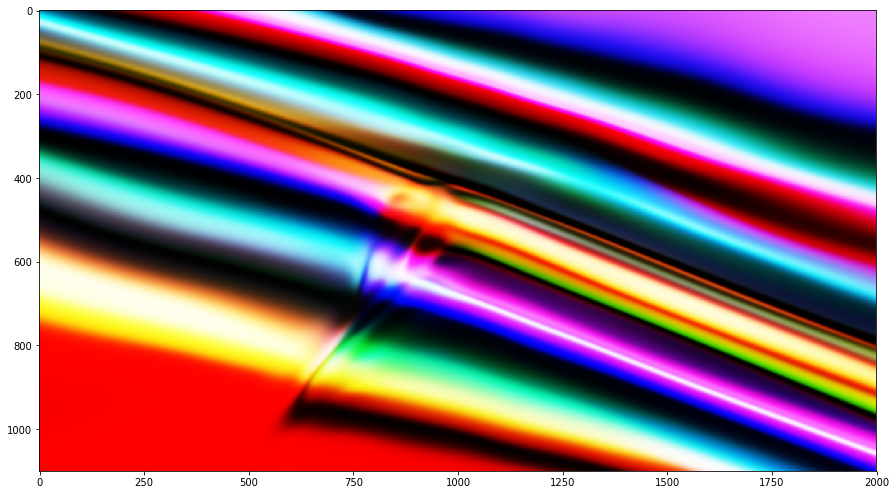

In [29]:
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

In [ ]:
from dreamz.cppn import get_xy_mesh, CPPNNet
from torch import optim
from dreamz.render import render_vis
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
import numpy as np


class Net(nn.Module):
    def __init__(self, base_model, reps=2, output_channels=3):
        super(Net, self).__init__()
        self.base_model = base_model

        s = self.base_model.output_channels

        self.conv1 = self.get_group_of_layers(reps, s, s)
        self.conv2 = self.get_group_of_layers(reps - 1, s * 2, s)
        self.conv3 = nn.Conv2d(s * 2, output_channels, 3)
        self.final_act = nn.Sigmoid()

    def get_group_of_layers(self, reps, s0, s, k=1):
        this = []
        for i in range(reps):
            this += [nn.Conv2d(s0, s, k)]
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (s0 * (k ** 2)))
            )
#             this += [nn.ReLU6()]
            this += [Lambda(composite_activation)]
            s0 = s * 2
        return nn.Sequential(*this)

    def forward(self, x):
        x = self.base_model.layers(x)
        x = self.conv1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv2(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv3(x)
        x = self.final_act(x)
        return x[:, :, 3:-3, 3:-3]


device = 'cuda'
widths = [20] * 8

model = models.resnet18(pretrained=True).to(device)
model = nn.Sequential(*(
    [i for i in model.children()][:-4] + [
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()


base = CPPNNet(widths, output_channels=widths[-1])
viz = Net(base, reps=1).to(device)


size = [59, 105]


def train(size):
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

    def imgnet_objective(output):
        r = model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
        return -r[:, 30].mean()

    xy = get_xy_mesh(size).to(device)

    def im_gen_fn(num=16):
        xy_crop = []
        for i in range(num):
            x0 = np.random.randint(0, 105 - 59)
            xy_crop.append(xy[:, :, :, x0:x0 + 59])
        xy_crop = torch.cat(xy_crop, 0)
        return viz(xy_crop)
    opt = optim.Adam(viz.parameters(), lr=0.002)
    render_vis(imgnet_objective, im_gen_fn, opt, iters=150, log_interval=10)
    adjust_learning_rate(opt, 0.1)
    print('Adjusted learning rate')
    render_vis(imgnet_objective, im_gen_fn, opt, iters=50, log_interval=10)



/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2504: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


cost -0.04001147300004959


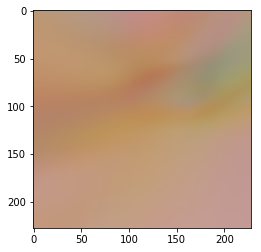

cost -0.32199281454086304


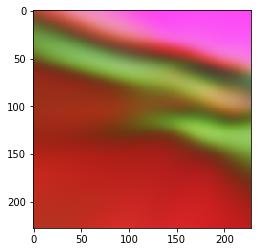

cost -0.7319972515106201


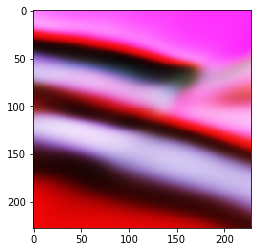

cost -0.9586955308914185


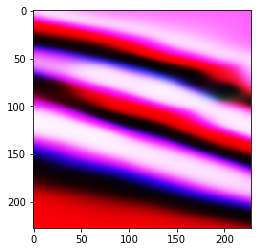

cost -1.0574253797531128


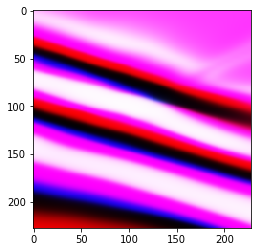

cost -1.120603084564209


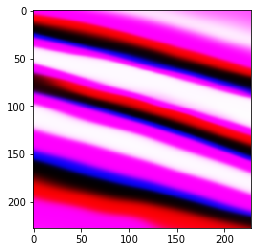

cost -1.1608922481536865


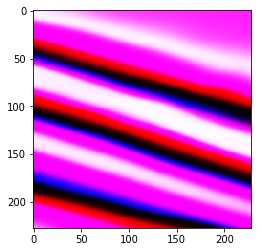

cost -1.1908851861953735


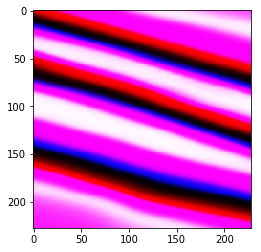

cost -1.2289879322052002


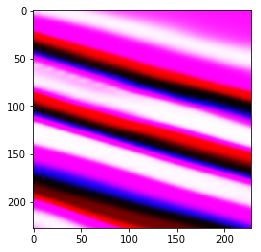

cost -1.2985423803329468


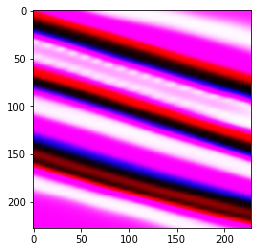

cost -1.3422878980636597


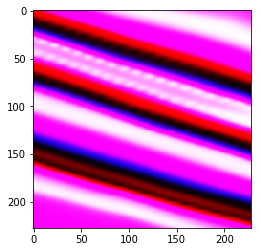

cost -1.3863524198532104


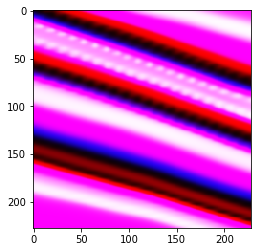

cost -1.402413010597229


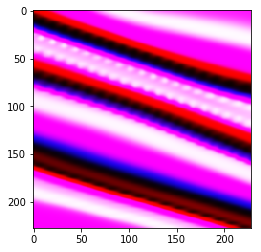

cost -1.4411972761154175


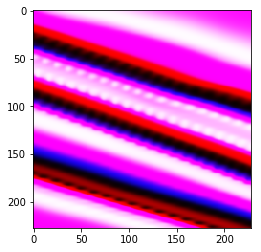

cost -1.4848417043685913


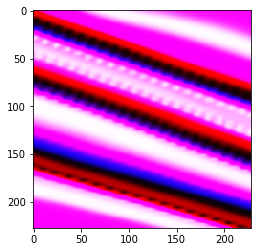

cost -1.5025732517242432


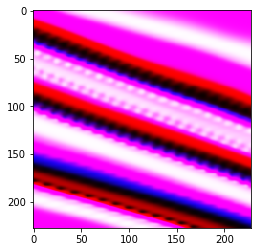

cost -1.538872480392456


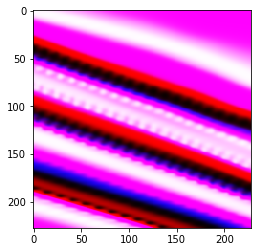

cost -1.5377202033996582


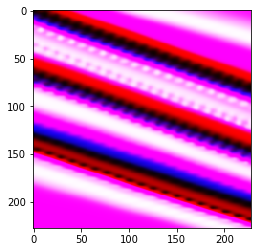

cost -1.5634527206420898


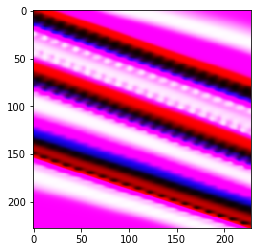

cost -1.554543375968933


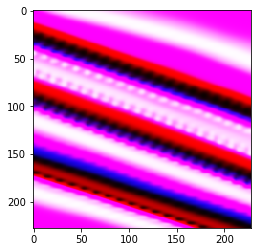

In [2]:
train(size)
xy_big = get_xy_mesh([277, 502]).to(device)


In [5]:

from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
res = viz(xy_big)
imsave(get_latest_filename('../data/output_ims/'), tch_im_to_np(res))


/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2504: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
